# **Box office revenue prediction**

**Shoval Zandberg 205791700**

**Noa Shmulevich 205737935**

Import libraries

In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import ast
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from textblob import TextBlob
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



Read the data

In [2]:
train_df = pd.read_csv("train.tsv",sep='\t')
train_df_copy = train_df.copy()


In [3]:
#converting column type

train_df['genres'] = train_df.genres.apply(lambda s: list(ast.literal_eval(s)))
train_df['production_companies'] = train_df.production_companies.apply(lambda s: list(ast.literal_eval(s)))
train_df['production_countries'] = train_df.production_countries.apply(lambda s: list(ast.literal_eval(s)))
train_df['spoken_languages'] = train_df.spoken_languages.apply(lambda s: list(ast.literal_eval(s)))
train_df['cast'] = train_df.cast.apply(lambda s: list(ast.literal_eval(s)))
train_df['crew'] = train_df.crew.apply(lambda s: list(ast.literal_eval(s)))

# **Initial Data analysis**

## Find Missing Data

Find all the missing values as we defined them in the report

In [4]:
train_df_copy['budget'] = np.where(train_df_copy['budget'] == 0, None, train_df_copy['budget'])
train_df_copy['crew'] = [item if len(item) > 3 else None for item in train_df_copy['crew']]
train_df_copy['cast'] = [item if len(item) > 3 else None for item in train_df_copy['cast']]
train_df_copy['genres'] = [item if len(item) > 3 else None for item in train_df_copy['genres']]
train_df_copy['production_companies'] = [item if len(item) > 3 else None for item in train_df_copy['production_companies']]
train_df_copy['production_countries'] = [item if len(item) > 3 else None for item in train_df_copy['production_countries']]
train_df_copy['spoken_languages'] = [item if len(item) > 3 else None for item in train_df_copy['spoken_languages']]
train_df_copy['Keywords'] = [item if len(item) > 3 else None for item in train_df_copy['Keywords']]

train_df_copy.isnull().sum(axis=0)

backdrop_path             577
belongs_to_collection    4150
budget                   1487
genres                     14
homepage                 3449
id                          0
imdb_id                    15
original_language           0
original_title              0
overview                    6
popularity                  0
poster_path               167
production_companies      170
production_countries       48
release_date                0
revenue                     0
runtime                     4
spoken_languages            8
status                      0
tagline                  1025
title                       0
video                       0
vote_average                0
vote_count                  0
Keywords                  400
cast                       10
crew                        7
dtype: int64

## Feature Distribution 

In [5]:
#data exploring - find all the genres, production_companies, production_countries, cast, crew
# and spoken_languages that exist in our data set in order to perform more analysis

genres_dict = dict()
production_companies_dict =dict()
production_countries_dict = dict()
spoken_languages_dict = dict()
actors_dict = dict()
crew_dict = {'Producer': dict(),'Director': dict(), 'Executive Producer': dict()}

for idx, row in train_df.iterrows():
  genres_list = row.genres
  prod_list = row.production_companies
  production_countries_list = row.production_countries
  spoken_languages_list = row.spoken_languages
  actors_list = row.cast
  crew_list = row.crew

  for g in genres_list:
    if g['name'] not in genres_dict.keys():
      genres_dict[g['name']] = 1
    else:
      genres_dict[g['name']]+=1

  for p in prod_list:
    if p['name'] not in production_companies_dict.keys():
      production_companies_dict[p['name']] = 1
    else:
      production_companies_dict[p['name']]+=1

  for c in production_countries_list:
    if c['name'] not in production_countries_dict.keys():
      production_countries_dict[c['name']] = 1
    else:
      production_countries_dict[c['name']]+=1

  for l in spoken_languages_list:
    if l['name'] not in spoken_languages_dict.keys():
      spoken_languages_dict[l['name']] = 1
    else:
      spoken_languages_dict[l['name']]+=1

  for a in actors_list:
    if a['name'] not in actors_dict.keys():
      actors_dict[a['name']] = 1
    else:
      actors_dict[a['name']]+=1

  for c in crew_list:
    if c['job'] not in ['Producer','Director', 'Executive Producer']:
      continue
    if c['name'] not in crew_dict[c['job']].keys():
      crew_dict[c['job']][c['name']] = 1
    else:
      crew_dict[c['job']][c['name']]+=1

In [6]:
from collections import OrderedDict
for key, value in crew_dict.items():
   crew_dict[key] = OrderedDict(sorted(value.items(), key=lambda x: x[1], reverse = True))

actors_dict = OrderedDict(sorted(actors_dict.items(), key=lambda x: x[1], reverse = True))
sort_production_countries= sorted(production_countries_dict.items(), key=lambda x: x[1], reverse=True)

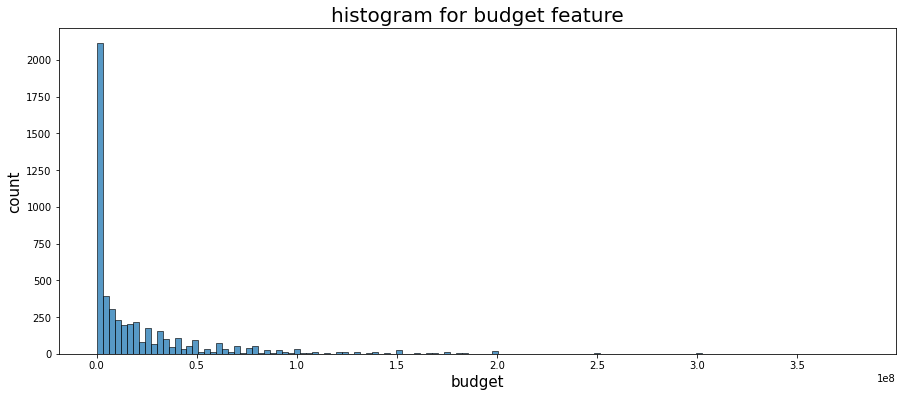

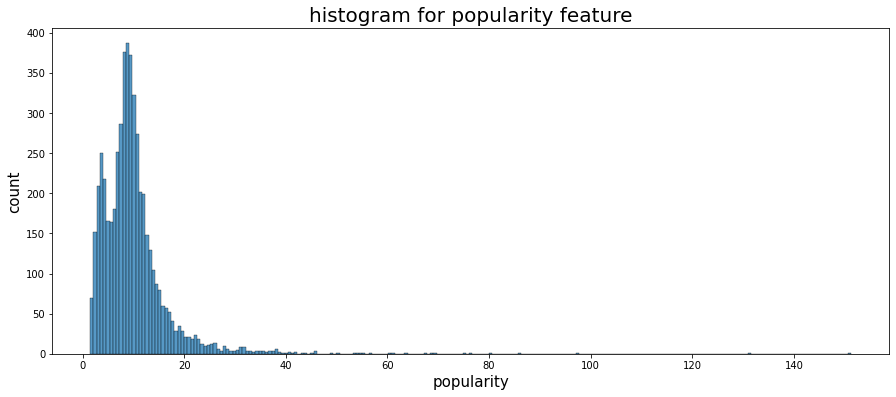

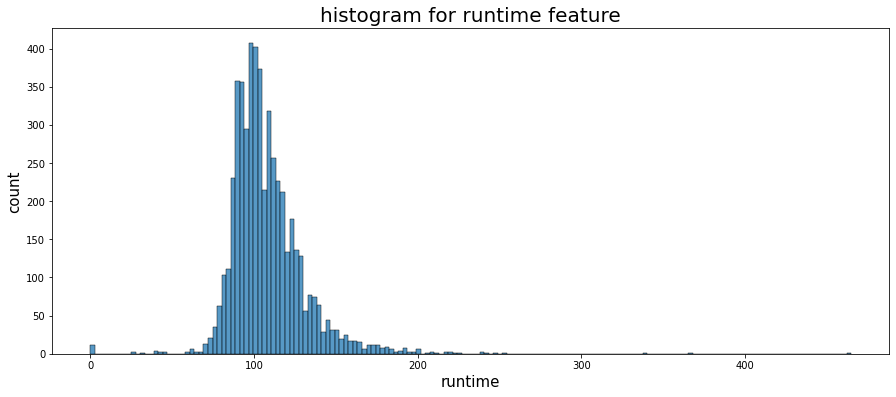

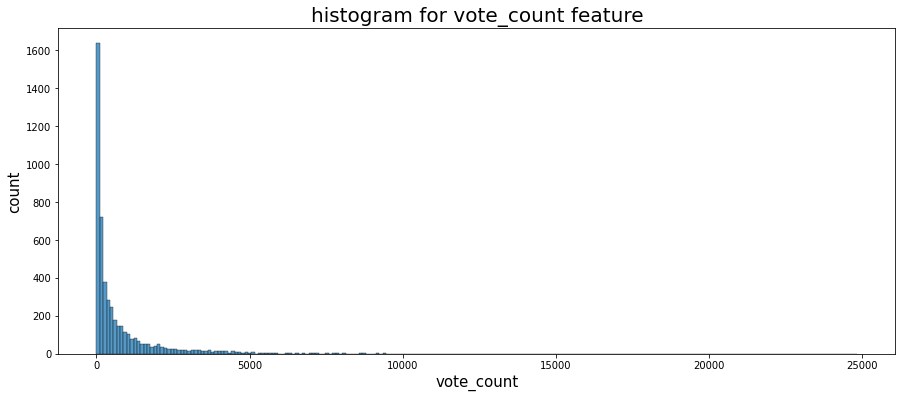

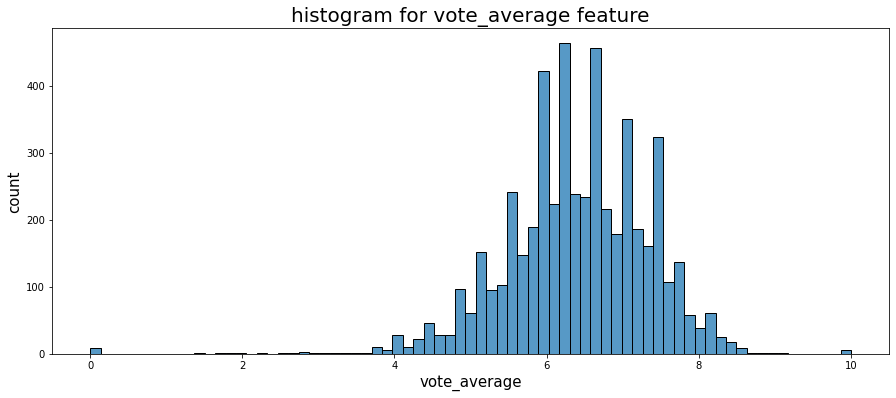

In [7]:
columns = ['budget', 'popularity', 'runtime', 'vote_count','vote_average']
for col in columns:
  fig, ax = plt.subplots(figsize=(15,6))
  ax = sns.histplot(train_df[col])
  ax.set_title(f'histogram for {col} feature',fontdict={'size':20})
  ax.set_xlabel(col, fontdict={'size':15})
  ax.set_ylabel('count', fontdict={'size':15})
  plt.show()

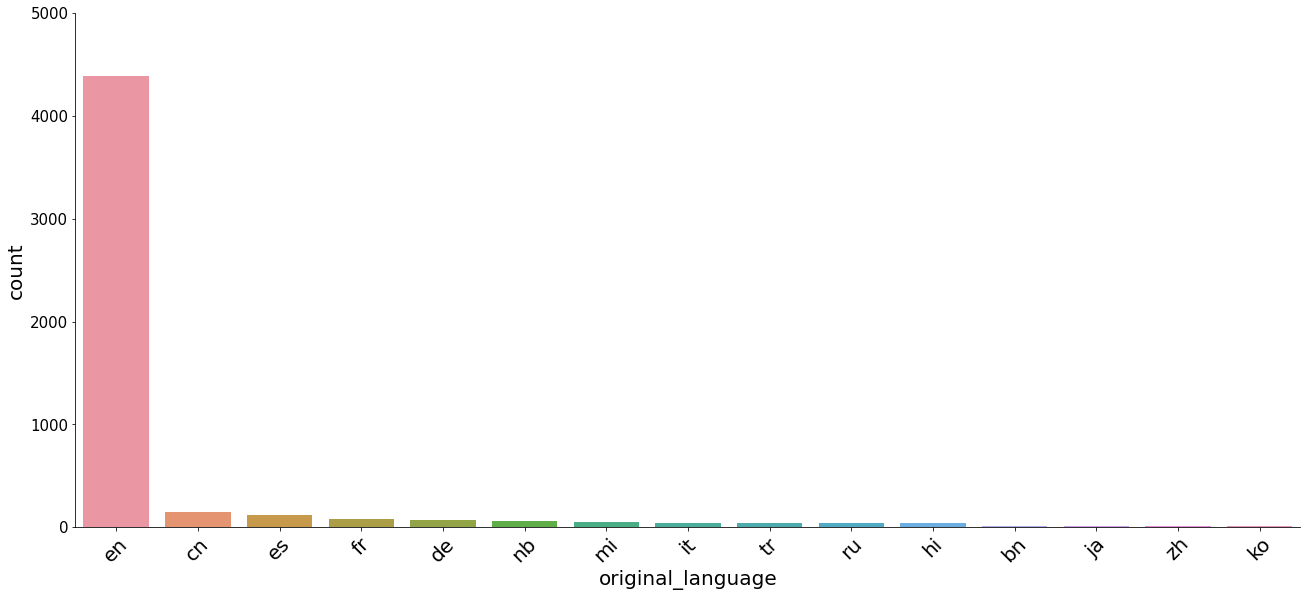

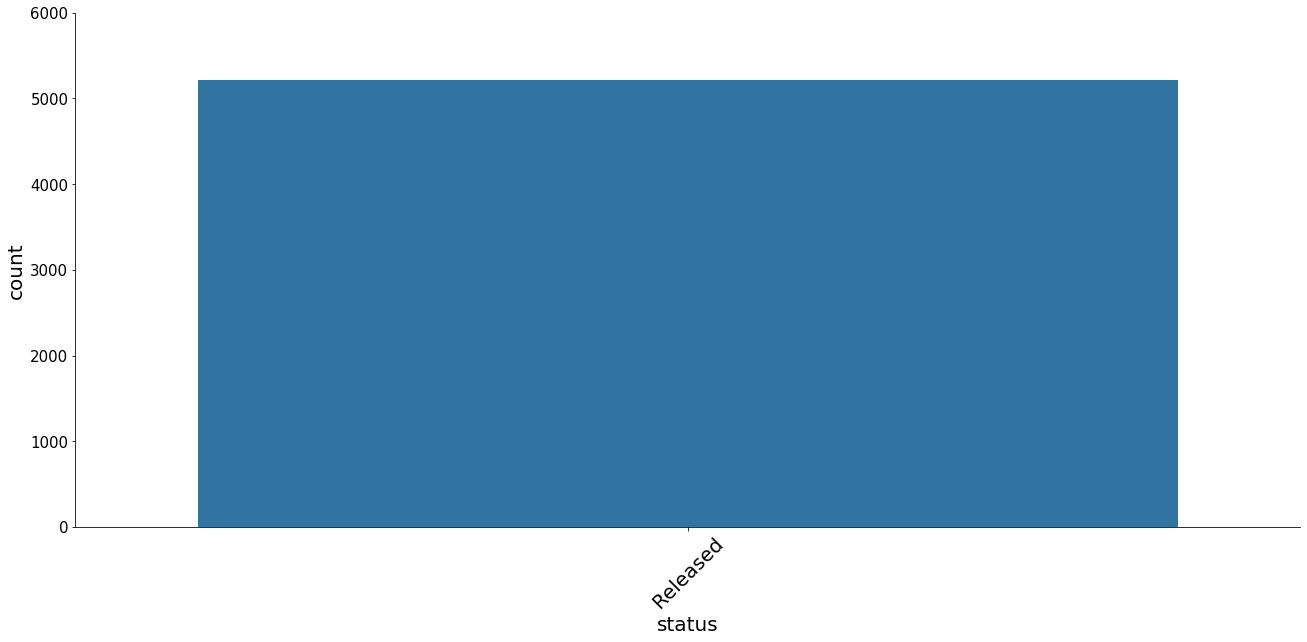

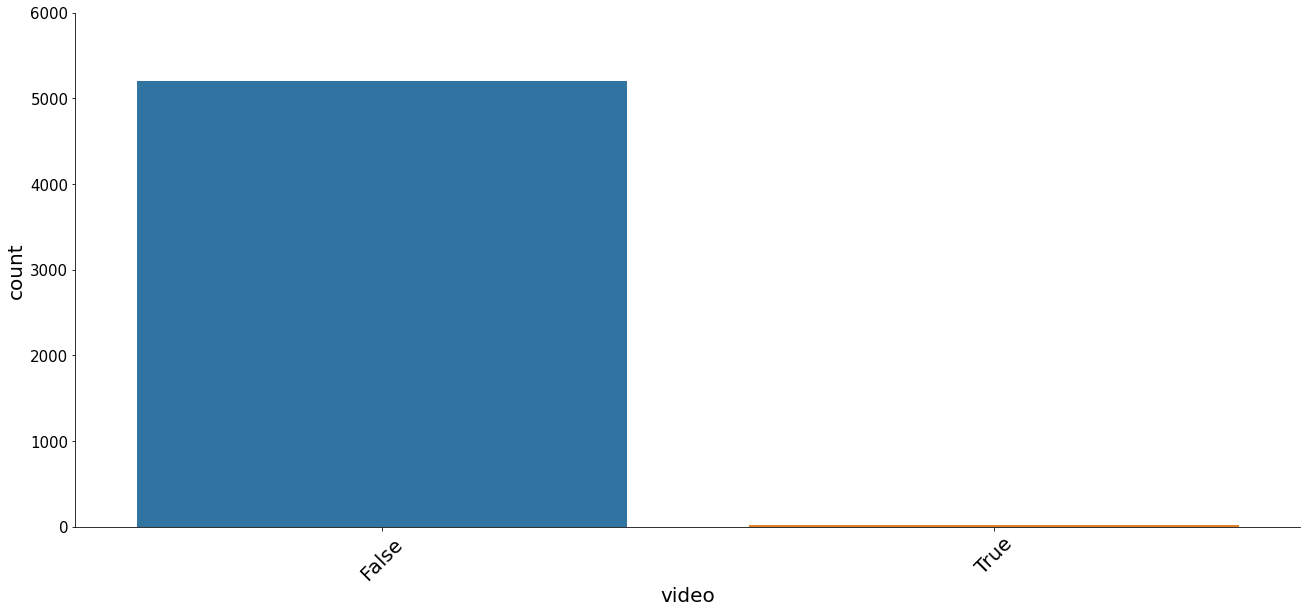

In [8]:
for col in ['original_language','status','video']:
  data = {col:list(train_df[col].unique()), 'count':list(train_df[col].value_counts()) }
  tmp = pd.DataFrame(data=data)
  tmp = tmp.sort_values(by='count', ascending=False)
  tmp = tmp[0:15]
  g = sns.catplot(x = col, y="count", data=tmp, kind="bar")
  g.set_xticklabels(rotation=45, size=20)
  g.set_yticklabels(size=15)
  g.set_ylabels(size=20)
  g.set_xlabels(size=20)
  g.fig.set_figwidth(20)
  g.fig.set_figheight(8)

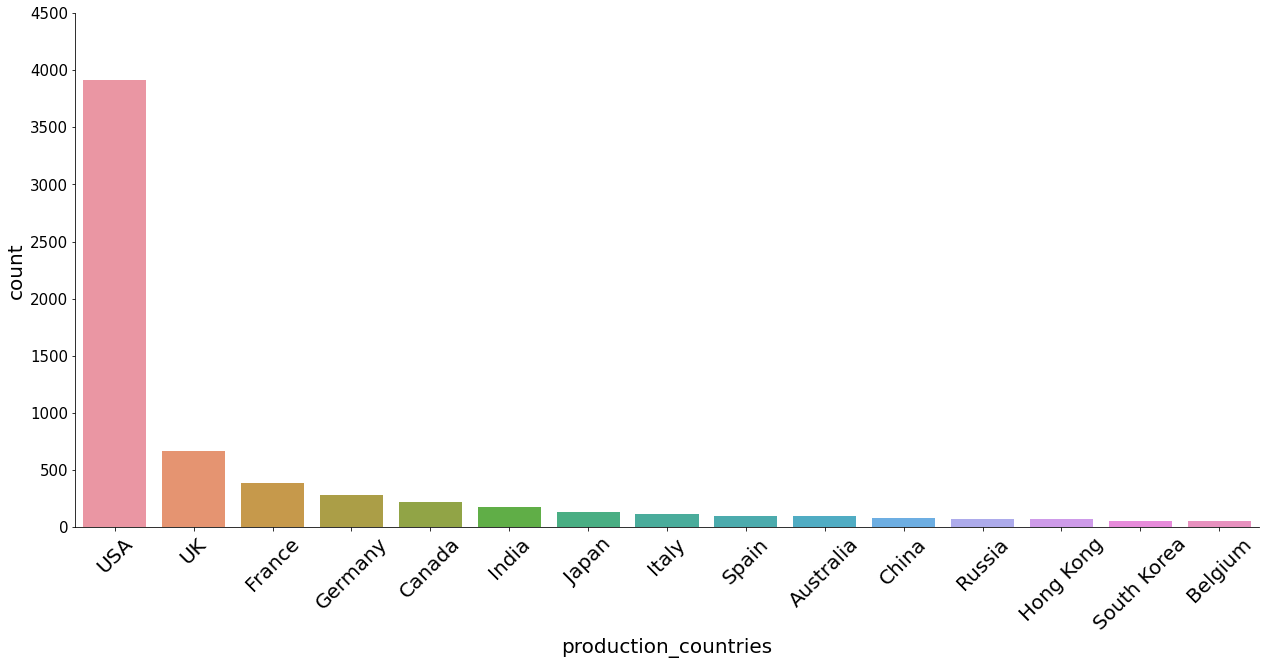

In [9]:
data = {'production_countries':list(production_countries_dict.keys()), 'count':list(production_countries_dict.values()) }
tmp = pd.DataFrame(data=data)
tmp['production_countries'] = np.where(tmp['production_countries'] == 'United States of America', 'USA',tmp['production_countries'])
tmp['production_countries'] = np.where(tmp['production_countries'] == 'United Kingdom', 'UK',tmp['production_countries'])
tmp = tmp.sort_values(by='count', ascending=False)
tmp = tmp[:15]
g = sns.catplot(x = "production_countries", y="count", data=tmp, kind="bar")
g.set_xticklabels(rotation=45, size=20)
g.set_yticklabels(size=15)
g.set_ylabels(size=20)
g.set_xlabels(size=20)
g.fig.set_figwidth(20)
g.fig.set_figheight(8)

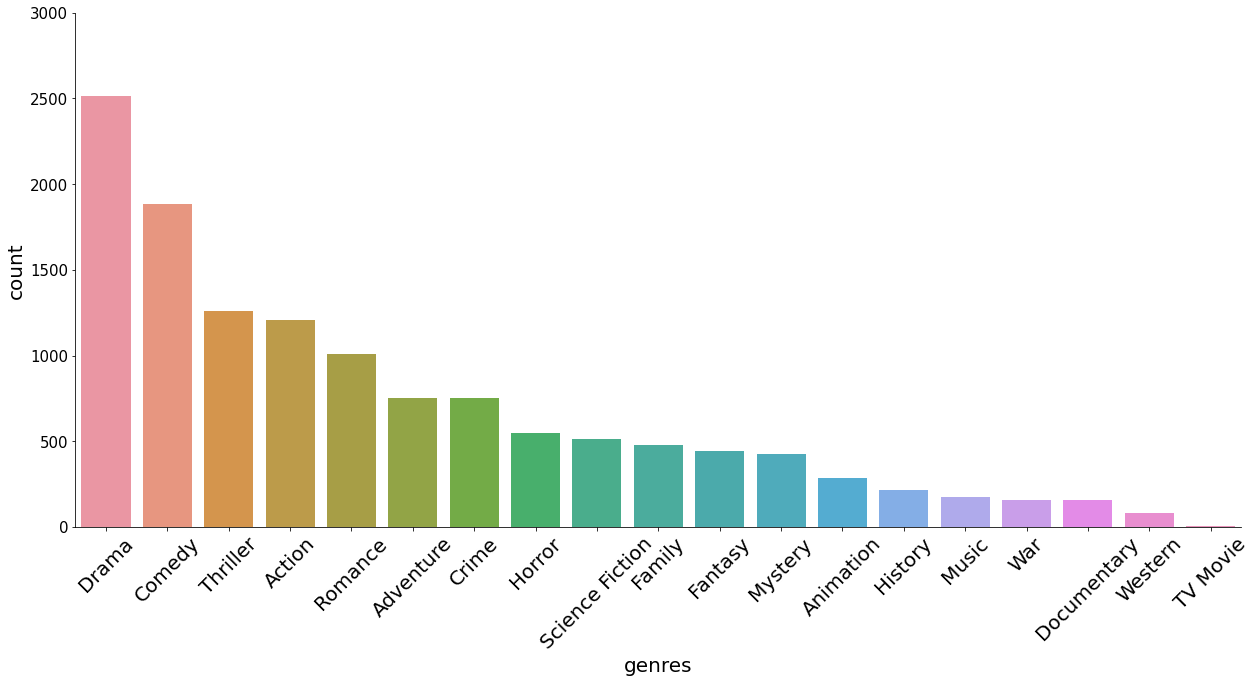

In [10]:
data = {'genres':list(genres_dict.keys()), 'count':list(genres_dict.values()) }
tmp = pd.DataFrame(data=data)
tmp = tmp.sort_values(by='count', ascending=False)
g = sns.catplot(x = "genres", y="count", data=tmp, kind="bar")
g.set_xticklabels(rotation=45, size=20)
g.set_yticklabels(size=15)
g.set_ylabels(size=20)
g.set_xlabels(size=20)
g.fig.set_figwidth(20)
g.fig.set_figheight(8)

In [11]:
sort_spoken_languages = sorted(spoken_languages_dict.items(), key=lambda x: x[1], reverse=True)
sort_production_companies = sorted(production_companies_dict.items(), key=lambda x: x[1], reverse=True)
sort_production_companies = dict(sort_production_companies)
sort_production_companies_df = pd.DataFrame(columns=['name','val'])
sort_production_companies_df['name'] =sort_production_companies.keys()
sort_production_companies_df['val']=sort_production_companies.values()

fig = px.bar(sort_production_companies_df, x='name', y='val')
fig.show()


In [12]:
sort_actors_dict = sorted(actors_dict.items(), key=lambda x: x[1], reverse=True)
sort_actors_dict = dict(sort_actors_dict)
sort_actors_dict_df = pd.DataFrame(columns=['name','count'])
sort_actors_dict_df['name'] =sort_actors_dict.keys()
sort_actors_dict_df['count']=sort_actors_dict.values()
sort_actors_dict_df = sort_actors_dict_df[0:20]

fig = px.bar(sort_actors_dict_df, x='name', y='count')
fig.update_layout(width=1000, title= 'Actors histogram')
fig.show()

In [13]:
sort_crew_director_dict = sorted(crew_dict['Director'].items(), key=lambda x: x[1], reverse=True)
sort_crew_director_dict = dict(sort_crew_director_dict)
sort_crew_director_dict_df = pd.DataFrame(columns=['name','count'])
sort_crew_director_dict_df['name'] =sort_crew_director_dict.keys()
sort_crew_director_dict_df['count']=sort_crew_director_dict.values()
sort_crew_director_dict_df = sort_crew_director_dict_df[0:10]
fig = px.bar(sort_crew_director_dict_df, x='name', y='count')
fig.update_layout(width=700, title= 'Director histogram')
fig.show()

In [14]:
p = set(crew_dict['Producer'].keys())
p_e = set(crew_dict['Executive Producer'].keys())
d = set(crew_dict['Director'].keys())


In [15]:
sort_crew_producer_dict = sorted(crew_dict['Producer'].items(), key=lambda x: x[1], reverse=True)
sort_crew_producer_dict = dict(sort_crew_producer_dict)
sort_crew_producer_dict_df = pd.DataFrame(columns=['name','count'])
sort_crew_producer_dict_df['name'] =sort_crew_producer_dict.keys()
sort_crew_producer_dict_df['count']=sort_crew_producer_dict.values()
sort_crew_producer_dict_df = sort_crew_producer_dict_df[0:10]
fig = px.bar(sort_crew_producer_dict_df, x='name', y='count')
fig.update_layout(width=700, title= 'Producer histogram')
fig.show()

In [16]:
sort_crew_ex_producer_dict = sorted(crew_dict['Executive Producer'].items(), key=lambda x: x[1], reverse=True)
sort_crew_ex_producer_dict = dict(sort_crew_ex_producer_dict)
sort_crew_ex_producer_dict_df = pd.DataFrame(columns=['name','count'])
sort_crew_ex_producer_dict_df['name'] =sort_crew_ex_producer_dict.keys()
sort_crew_ex_producer_dict_df['count']=sort_crew_ex_producer_dict.values()
sort_crew_ex_producer_dict_df = sort_crew_ex_producer_dict_df[0:10]
fig = px.bar(sort_crew_ex_producer_dict_df, x='name', y='count')
fig.update_layout(width=700, title= 'Executive Producer histogram')
fig.show()

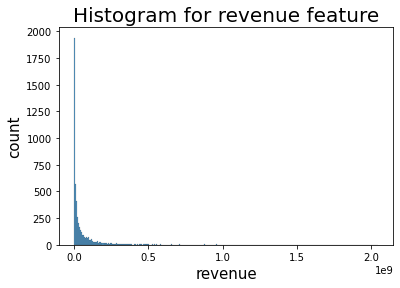

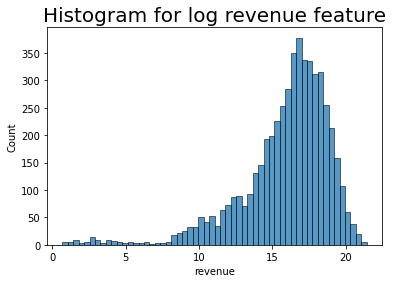

In [17]:
ax = sns.histplot(train_df.revenue)
ax.set_title('Histogram for revenue feature',fontdict={'size':20})
ax.set_xlabel('revenue', fontdict={'size':15})
ax.set_ylabel('count', fontdict={'size':15})
plt.show()

ax1 = sns.histplot(np.log1p(train_df.revenue))
ax1.set_title('Histogram for log revenue feature',fontdict={'size':20})
ax.set_xlabel('revenue', fontdict={'size':15})
ax.set_ylabel('count', fontdict={'size':15})
plt.show()



#**Data pre-processing**

## Fill mising values

In [18]:
train_df['overview'] = np.where(train_df['overview'].isna(),'',train_df['overview'])
train_df['has_homepage'] = np.where(train_df['homepage'].isna(),0,1)
train_df['has_collection'] = np.where(train_df['belongs_to_collection'].isna(),0,1)
train_df['has_tagline'] = np.where(train_df['tagline'].isna(),0,1)
train_df['budget'].replace({0: None}, inplace=True)
train_df['update_budget']= train_df['budget'].fillna((train_df['budget'].median()))

## create new features

In [20]:
# create 'multi hot' vector for genres
g_list = list()
different_g = list()
for genres in train_df.genres:
  tmp =[]
  for i in genres:
    tmp.append(i['name'])
    if i['name'] not in different_g:
      different_g.append(i['name'])
  g_list.append(tmp)

train_df['new_genre'] = g_list
for g in different_g:
  train_df[g] = np.where(train_df['new_genre'].str.contains(g,regex=False),1,0)

In [22]:
# create binary features
train_df['is_original_language_en'] = np.where(train_df['original_language']=='en',1,0)
train_df['amount_of_genre'] = [len(i) for i in train_df.new_genre]

#Create columns for month and year and year_bins
train_df['month'] = pd.DatetimeIndex(train_df['release_date']).month
train_df['year'] = pd.DatetimeIndex(train_df['release_date']).year
train_df['is_holiday'] = np.where(train_df['month'].isin([11,12,5,6,7]),1,0)



In [23]:
train_df['budget_year_ratio'] = round(train_df['update_budget']/train_df['year'], 2)
train_df['popularity_year_ratio'] = round(train_df['popularity']/train_df['year'], 2)
train_df['vote_count_year_ratio'] = round(train_df['vote_count']/train_df['year'], 2)

train_df['sentiment_overview'] = train_df['overview'].map(lambda text: TextBlob(text).sentiment.polarity)
train_df['sentiment_title'] = train_df['title'].map(lambda text: TextBlob(text).sentiment.polarity)

train_df['inflation_Budget'] = train_df['update_budget'] + (train_df['update_budget']*1.8)/(100*(2020-train_df['year']))
train_df['log_budget'] = np.log1p(train_df['update_budget'])
train_df['log_revenue'] =  np.log1p(train_df['revenue'])
train_df['video'] = np.where(train_df['video']==True,1,0)

In [24]:
# create binary feature for country beeing us or not
def is_in_list(x):
  for item in x:
    if item =='United States of America':
      return 1
  return 0

c_list = list()
for country in train_df.production_countries:
  tmp =[]
  for i in country:
    tmp.append(i['name'])
  c_list.append(tmp)

train_df['country'] = c_list
train_df['is_country_us'] = train_df['country'].apply(is_in_list)
train_df['is_country_us'].value_counts()


1    3917
0    1298
Name: is_country_us, dtype: int64

In [25]:
# create binary feature for popular production company
def is_in_list(x,top_p):
  for item in x:
    if item in top_p:
      return 1
  return 0

p_list, producer_list, e_producer_list, director_list, actors_list = list(),list(),list(),list(), list()
top_p = list(sort_production_companies_df['name'][0:10])
top_producer = list(crew_dict['Producer'])[0:10]
top_e_producer = list(crew_dict['Executive Producer'])[0:10]
top_director = list(crew_dict['Director'])[0:10]
top_actore = list(actors_dict)[0:50]

for production in train_df.production_companies:
  tmp =[]
  for i in production:
    tmp.append(i['name'])
  p_list.append(tmp)

for c in train_df.crew:
  tmp_p, tmp_e_p, tmp_d =[],[],[]
  for i in c:
    if i['job']== 'Producer':
      tmp_p.append(i['name'])
    elif i['job']== 'Executive Producer':
      tmp_e_p.append(i['name'])
    else:
      tmp_d.append(i['name'])
  producer_list.append(tmp_p)
  e_producer_list.append(tmp_e_p)
  director_list.append(tmp_d)

for a in train_df.cast:
  tmp =[]
  for i in a:
    tmp.append(i['name'])
  actors_list.append(tmp)


train_df['new_production'] = p_list
train_df['new_producer'] = producer_list
train_df['new_e_producer'] = e_producer_list
train_df['new_director'] = director_list
train_df['new_actor'] = actors_list

train_df['is_in_popular_production'] = train_df['new_production'].apply(is_in_list,args=(top_p,))
train_df['is_in_popular_producer'] = train_df['new_producer'].apply(is_in_list,args=(top_producer,))
train_df['is_in_popular_executive_producer'] = train_df['new_e_producer'].apply(is_in_list,args=(top_e_producer,))
train_df['is_in_popular_director'] = train_df['new_director'].apply(is_in_list,args=(top_director,))
train_df['is_in_popular_actores'] = train_df['new_actor'].apply(is_in_list,args=(top_actore,))


## More analysis for some of the new feature

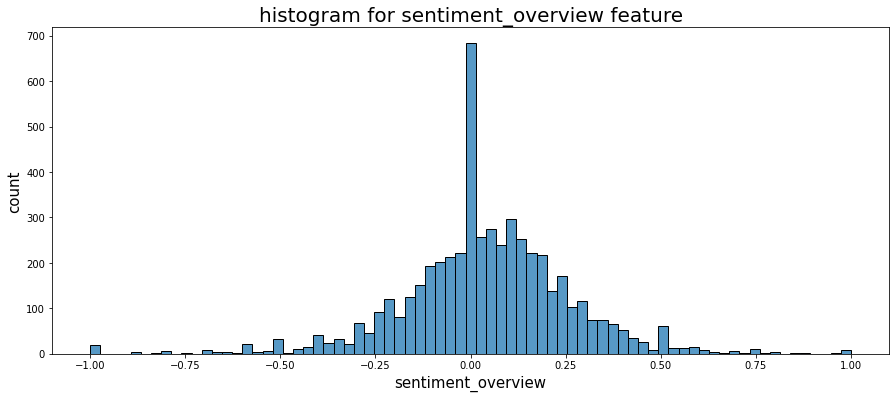

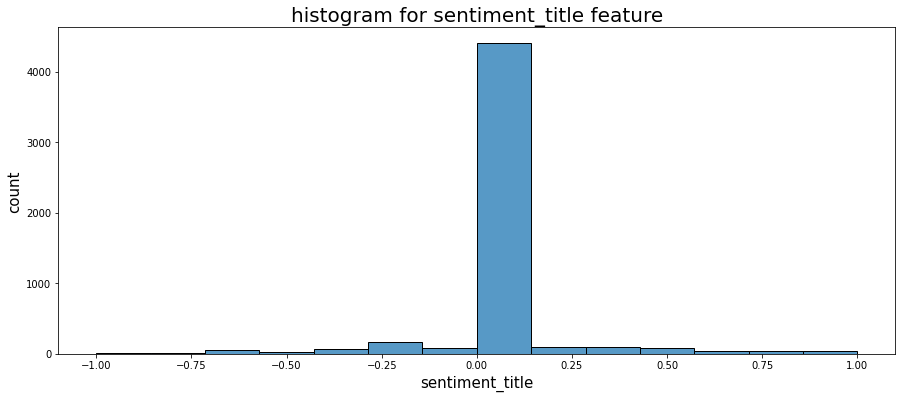

In [26]:
for col in ['sentiment_overview','sentiment_title']  :
  fig, ax = plt.subplots(figsize=(15,6))
  ax = sns.histplot(train_df[col])
  ax.set_title(f'histogram for {col} feature',fontdict={'size':20})
  ax.set_xlabel(col, fontdict={'size':15})
  ax.set_ylabel('count', fontdict={'size':15})
  plt.show()

# **Feature selection**

In [28]:
# define our new train set
train_df_new = train_df[['revenue','has_tagline','popularity','runtime','video','vote_average','vote_count','is_original_language_en','has_homepage',
                         'update_budget','month','is_in_popular_production','is_country_us','has_collection','amount_of_genre','year',
                         'Fantasy','Action','Adventure','Comedy','Horror','Documentary','Mystery','Thriller','Science Fiction','Drama',
                         'Romance','Crime','War','History','Music','Family','Animation','Western','budget_year_ratio', 'sentiment_overview', 'sentiment_title',
                         'is_in_popular_producer', 'is_in_popular_executive_producer', 'is_in_popular_director', 'is_in_popular_actores','is_holiday',
                         'popularity_year_ratio', 'vote_count_year_ratio',
                         'inflation_Budget', 'log_budget']]

## Pearson corelation map

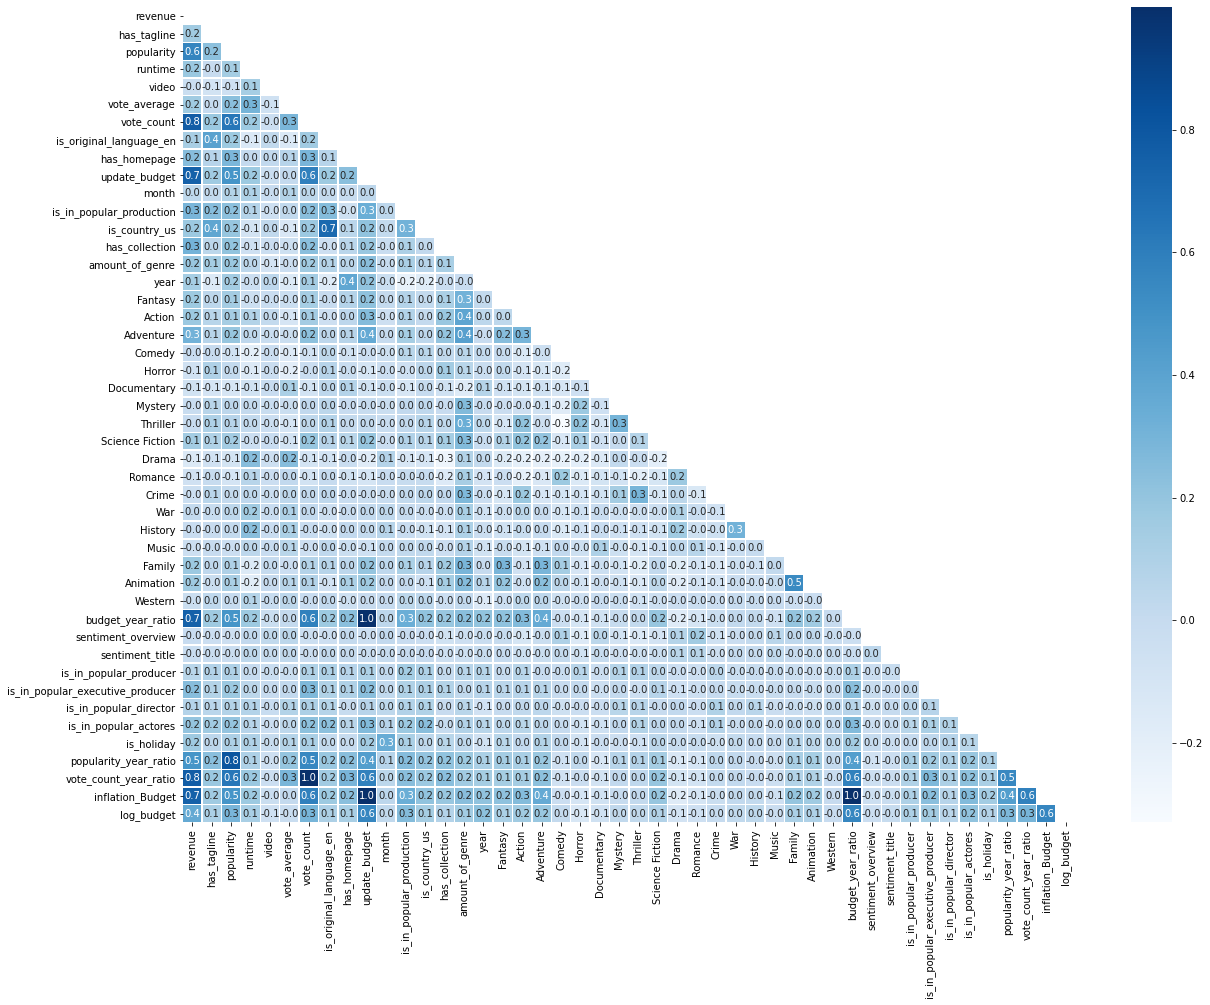

In [29]:
f,ax = plt.subplots(figsize=(20, 15))
mask = np.zeros_like(train_df_new.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_df_new.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Blues",mask=mask)
plt.show()

### looking at the distribution of the different features with respect to revenue

In [31]:
for col in ['is_in_popular_production','is_country_us','is_original_language_en','has_homepage','has_collection','has_tagline','amount_of_genre','month','is_holiday']:
  fig = px.box(train_df, x=col, y="revenue", points="all",title=f'{col} Vs. revenue')
  fig.update_layout(title_x=0.5, width=500)
  if col == 'month':
    fig.update_layout(width=1000,xaxis = dict(
          tickmode = 'array',
          tickvals = [i for i in range(13)],
          ticktext = [i for i in range(13)]))
  fig.show()



In [32]:
for col in ['popularity','update_budget','vote_average','vote_count','budget_year_ratio']:
  fig = px.scatter(train_df, x=col, y="revenue",title=f'{col} Vs. reveneu', trendline='ols', trendline_color_override='firebrick')
  if col == 'update_budget':
    fig.update_xaxes(title='budget')
  fig.update_layout(title_x=0.5, width=700)
  fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [33]:
import plotly.graph_objects as go

def plot_genre(columns):
  fig = go.Figure()
  for col in columns:
    y_1 = train_df[train_df[col] == 1]['revenue'].values
    fig.add_trace(go.Box(y=y_1, name=f'{col} = 1',marker_color='#3D9970',boxpoints='all'))
    y_0 = train_df[train_df[col] == 0]['revenue'].values
    fig.add_trace(go.Box(y=y_0, name=f'{col} = 0',marker_color='#FF4136',boxpoints='all'))

  fig.update_layout(title='genres Vs. reveneu',title_x=0.5,showlegend=False,width=700) 
  fig.update_yaxes(title='revenue')
  fig.update_xaxes(title='genre')
  fig.show()
plot_genre(['Drama','Comedy','Thriller','Action','Romance','Adventure'])
plot_genre(['Crime','Horror','Science Fiction','Family','Mystery'])
plot_genre(['Animation','History','Music','War','Documentary','Western','TV Movie'])


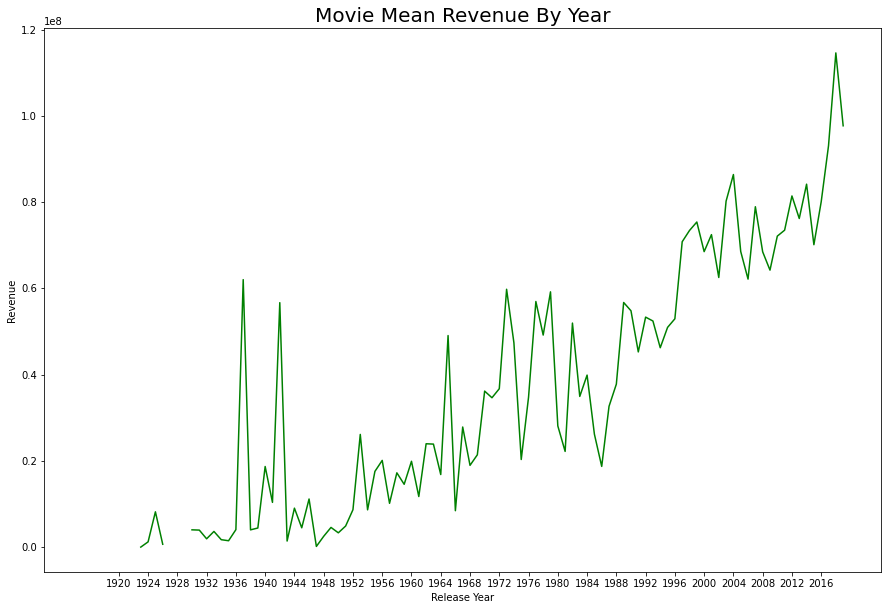

In [34]:
train_df['meanRevenueByYear'] = train_df.groupby("year")["revenue"].aggregate('mean')
train_df['meanRevenueByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2020,4))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=20)
plt.show()

### Filter methods-
We will find all the feature that have at least 0.3 correlation score with revenue

In [30]:
correlation = train_df_new.corr()['revenue'].iloc[1:]
top_k_correlated_feature = correlation[correlation>=0.3]
top_k_correlated_feature.index.tolist()

['popularity',
 'vote_count',
 'update_budget',
 'has_collection',
 'Adventure',
 'budget_year_ratio',
 'popularity_year_ratio',
 'vote_count_year_ratio',
 'inflation_Budget',
 'log_budget']

## Wrapper method

In [ ]:
train_df_new.dropna(subset=['runtime'], inplace=True)
X_train = train_df_new.drop(columns=['revenue'], axis=1)
y_train = train_df_new['revenue']
y_train_log = np.log1p(y_train)

In [37]:
def wrapper_method(X_train, Y_train, model, num_features):
  classifier_pipeline = make_pipeline(MinMaxScaler(), model)
  sfs1 = SFS(classifier_pipeline,
            k_features=num_features,  
            forward=True, 
            scoring='neg_mean_squared_log_error'
            )
  sfs1.fit(X_train,Y_train)

  return  list(sfs1.k_feature_names_), sfs1.subsets_[len(sfs1.subsets_)]['avg_score']

### Random forest selection

In [40]:
model = RandomForestRegressor(max_depth=10, random_state=0).fit(X_train, y_train_log)
feature_list, sfs= wrapper_method(X_train, y_train_log, model, 'best')

In [41]:
feature_list, sfs


### Xgb

In [48]:
pip install xgboost

In [ ]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7, learning_rate = 0.01,
                max_depth = 6, alpha = 0, n_estimators = 100)
xg_reg.fit(X_train,y_train_log)
feature_list, sfs= wrapper_method(X_train, y_train_log, xg_reg, 'best')
print(feature_list)

### CatBoost

In [ ]:
import catboost 

model = catboost.CatBoostRegressor(iterations=700, early_stopping_rounds=100,rsm=0.8,
                                   learning_rate=0.01,depth=5, random_state=42,eval_metric='MSLE').fit(x_train, y_train)
feature_list, sfs= wrapper_method(X_train, y_train_log, model, 'best')
print(feature_list)